# Boosted decision trees with xgboost
Authors: Raghav Kansal

Run this cell to download the data if you did not already download it in from Tutorial #1:

In [1]:
!mkdir -p data
!wget -O data/ntuple_4mu_bkg.root "https://zenodo.org/record/3901869/files/ntuple_4mu_bkg.root?download=1"
!wget -O data/ntuple_4mu_VV.root "https://zenodo.org/record/3901869/files/ntuple_4mu_VV.root?download=1"

--2024-01-09 17:58:50--  https://zenodo.org/record/3901869/files/ntuple_4mu_bkg.root?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3901869/files/ntuple_4mu_bkg.root [following]
--2024-01-09 17:58:51--  https://zenodo.org/records/3901869/files/ntuple_4mu_bkg.root
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 8867265 (8.5M) [application/octet-stream]
Saving to: ‘data/ntuple_4mu_bkg.root’

100%[======================================>] 8,867,265   5.55MB/s   in 1.5s   

2024-01-09 17:58:53 (5.55 MB/s) - ‘data/ntuple_4mu_bkg.root’ saved [8867265/8867265]

--2024-01-09 17:58:53--  https://zenodo.org/record/3901869/files/ntuple_4mu_VV.root?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [2]:
import uproot
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = "HZZ4LeptonsAnalysisReduced"
filename = {}
upfile = {}
df = {}

filename["VV"] = "data/ntuple_4mu_VV.root"
filename["bkg"] = "data/ntuple_4mu_bkg.root"

VARS = ["f_mass4l", "f_massjj"]  # choose which vars to use (2d)

upfile["VV"] = uproot.open(filename["VV"])
upfile["bkg"] = uproot.open(filename["bkg"])

df["bkg"] = upfile["bkg"][treename].arrays(VARS, library="pd")
df["VV"] = upfile["VV"][treename].arrays(VARS, library="pd")

# cut out undefined variables VARS[0] and VARS[1] > -999
df["VV"] = df["VV"][(df["VV"][VARS[0]] > -999) & (df["VV"][VARS[1]] > -999)]
df["bkg"] = df["bkg"][(df["bkg"][VARS[0]] > -999) & (df["bkg"][VARS[1]] > -999)]

# add isSignal variable
df["VV"]["isSignal"] = np.ones(len(df["VV"]))
df["bkg"]["isSignal"] = np.zeros(len(df["bkg"]))

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 

In [3]:
NDIM = len(VARS)

df_all = pd.concat([df["VV"], df["bkg"]])
dataset = df_all.values
X = dataset[:, 0:NDIM]
Y = dataset[:, NDIM]

from sklearn.model_selection import train_test_split

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

## Define the model

We are using a simple boosted decision tree model from the xgboost library.

In [4]:
import xgboost as xgb

# see https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
# for detailed explanations of parameters
model = xgb.XGBClassifier(
    n_estimators=10,  # number of boosting rounds (i.e. number of decision trees)
    max_depth=1,  # max depth of each decision tree
    learning_rate=0.1,
    early_stopping_rounds=5,  # how many rounds to wait to see if the loss is going down
)

## Run training 
Here, we run the training.

In [5]:
trained_model = model.fit(
    X_train_val,
    Y_train_val,
    # xgboost uses the last set for early stopping
    # https://xgboost.readthedocs.io/en/stable/python/python_intro.html#early-stopping
    eval_set=[(X_train_val, Y_train_val), (X_test, Y_test)],  # sets for which to save the loss
    verbose=True,
)

[0]	validation_0-logloss:0.48588	validation_1-logloss:0.49037
[1]	validation_0-logloss:0.43483	validation_1-logloss:0.43617
[2]	validation_0-logloss:0.39488	validation_1-logloss:0.39379
[3]	validation_0-logloss:0.36247	validation_1-logloss:0.35934
[4]	validation_0-logloss:0.33569	validation_1-logloss:0.33082
[5]	validation_0-logloss:0.31318	validation_1-logloss:0.30684
[6]	validation_0-logloss:0.29404	validation_1-logloss:0.28647
[7]	validation_0-logloss:0.27773	validation_1-logloss:0.26900
[8]	validation_0-logloss:0.26370	validation_1-logloss:0.25397
[9]	validation_0-logloss:0.24876	validation_1-logloss:0.24161


## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

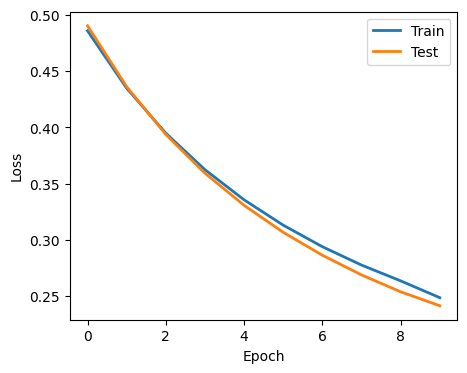

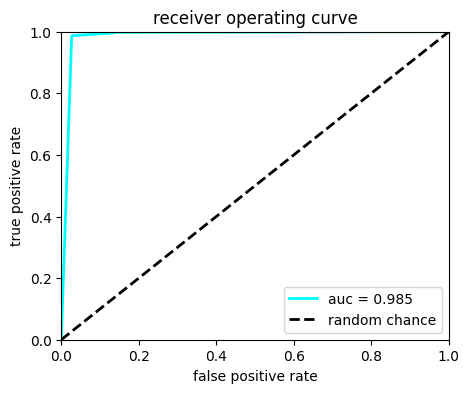

In [6]:
import matplotlib.pyplot as plt

evals_result = trained_model.evals_result()

fig = plt.figure(figsize=(5, 4))
for i, label in enumerate(["Train", "Test"]):
    plt.plot(evals_result[f"validation_{i}"]["logloss"], label=label, linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Plot ROC
Y_predict = model.predict_proba(X_test)
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, Y_predict[:, 1])
roc_auc = auc(fpr, tpr)


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="random chance")
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")
ax.set_title("receiver operating curve")
ax.legend(loc="lower right")
plt.show()

In [7]:
df_all["bdt"] = model.predict(X)  # add prediction to array
print(df_all.iloc[:5])

     f_mass4l     f_massjj  isSignal  bdt
0  125.077103  1300.426880       1.0    1
1  124.238113   437.221863       1.0    1
3  124.480667  1021.744080       1.0    1
4  124.919464  1101.381958       1.0    1
7  125.049065   498.717194       1.0    1


## Plot BDT output vs input variables
Here, we will plot the BDT output and devision boundary as a function of the input variables.

In [8]:
# make a regular 2D grid for the inputs
myXI, myYI = np.meshgrid(np.linspace(0, 1500, 200), np.linspace(0, 6000, 200))
# print shape
print(myXI.shape)

# run prediction at each point
myZI = model.predict_proba(np.c_[myXI.ravel(), myYI.ravel()])[:, 1]
myZI = myZI.reshape(myXI.shape)

(200, 200)


The code below shoes how to plot the BDT output and decision boundary. Does it look optimal?

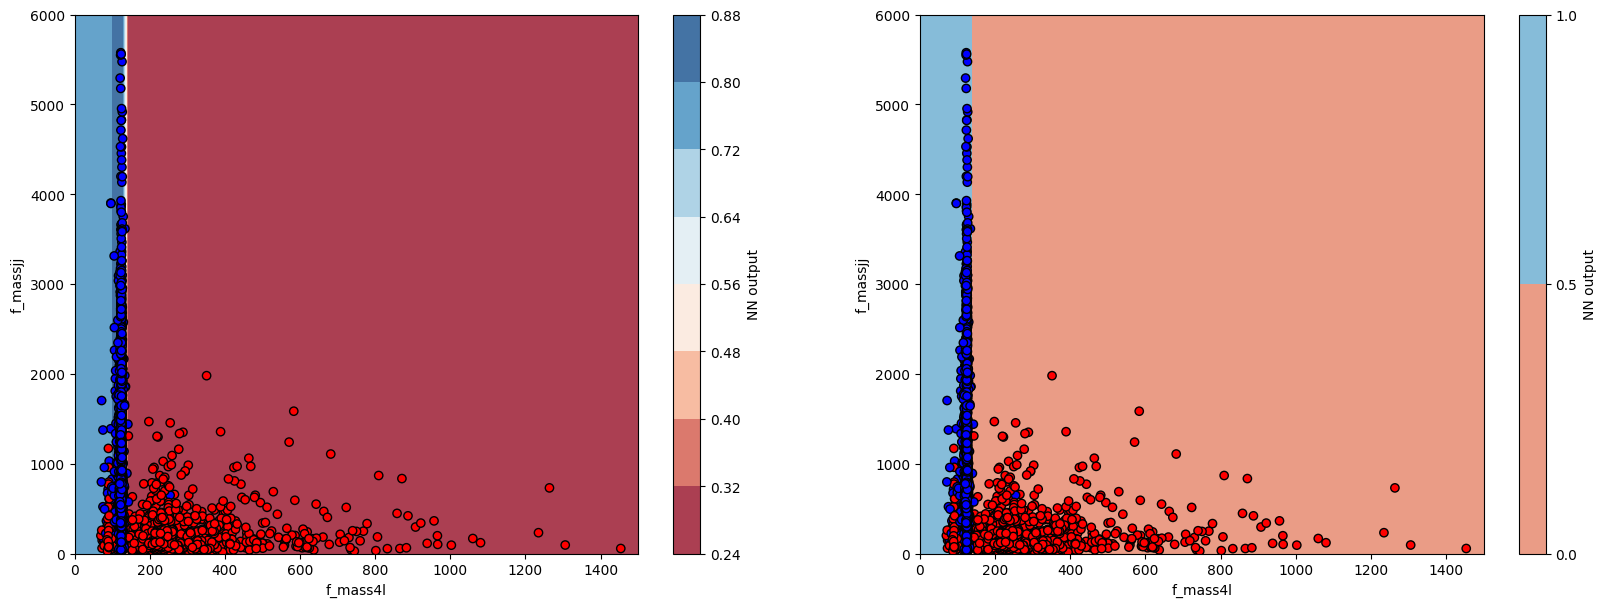

In [9]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(20, 7))

# plot contour map of BDT output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
cont_plot = ax.contourf(myXI, myYI, myZI, cmap=cm, alpha=0.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors="k")
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot, ax=ax, boundaries=[0, 1], label="NN output")

# plot decision boundary
# overlaid with test data points
ax = plt.subplot(1, 2, 2)
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
cont_plot = ax.contourf(myXI, myYI, myZI > 0.5, cmap=cm, alpha=0.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors="k")
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot, ax=ax, boundaries=[0, 1], label="NN output")
plt.show()

## Feature Importances

A nice feature of xgboost is that you can plot the relative importance of each feature to the BDT decision. Does this plot make sense?

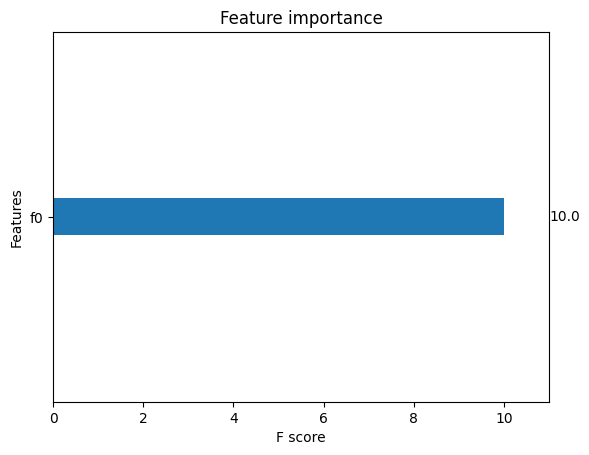

In [14]:
xgb.plot_importance(trained_model, grid=False)
plt.show()

**Question 1:** Can you explain the loss curve?

**Question 2:** Can you explain the decision boundary?

**Question 3:** How can you improve the BDT preformance?

**Question 4:** What happens if you add/remove early stopping?